In [1]:
import torch
import timm
import torch.nn as nn
from torchvision.models import alexnet
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import PIL.Image as Image


methods = {
    "gradcam": GradCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad
}

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_base_path = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/"

MODEL_DICT = {
    "densenet121": {
        "experiment_name": "05-change-classifier-head",
        "pretrained_weights": "densenet121_imagenet_1k_adamw_32_bce_aug_class/model.pth.tar",
    },
    "swin_in22k": {
        "experiment_name": "06-transformers-pre-trained",
        "pretrained_weights": "swin_base_imagenet_1k_sgd_64_bce_aug/model.pth.tar"
    },
    "vit_in1k": {
        "experiment_name": "06-transformers-pre-trained",
        "pretrained_weights": "vit_base_imagenet_1k_sgd_64_bce_True/model.pth.tar"
    },
    "swin_simim": {
        "experiment_name": "07-transformer-ssl",
        "pretrained_weights": "swin_base_simmim/model.pth.tar"
    },
}


In [3]:
def classifying_head(in_features: int, num_labels: int):
    return nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=in_features, out_features=128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=128),
        nn.Linear(128, num_labels),
    )

def load_model(pretrained_weights, num_labels, model_str):
    
    checkpoint = torch.load(
        pretrained_weights, map_location=torch.device('cpu'))
    state_dict = checkpoint['state_dict']

    if model_str == "densenet121":
        model = timm.create_model(
            'densenet121', num_classes=num_labels, pretrained=True)
        model.classifier = classifying_head(1024, num_labels)
    elif model_str == "swin_simim" or model_str == "swin_in22k":
        model = timm.create_model(
            'swin_base_patch4_window7_224_in22k', num_classes=num_labels, pretrained=True)
    elif model_str == "vit_in1k":
        model = timm.create_model('vit_base_patch16_224',
                                  num_classes=num_labels, pretrained=True)

    if model_str == "swin_simim":
        normalization = "chestx-ray"
    else: normalization = "imagenet"

    checkpoint = torch.load(pretrained_weights, map_location="cpu")

    state_dict = checkpoint['state_dict']
    msg = model.load_state_dict(state_dict, strict=False)
    print('Loaded with msg: {}'.format(msg))
    return model, normalization


In [11]:
swin_in22k_ckpt = model_base_path + MODEL_DICT["swin_in22k"]["experiment_name"] + "/" + MODEL_DICT["swin_in22k"]["pretrained_weights"]
swin_simim_ckpt = model_base_path + MODEL_DICT["swin_simim"]["experiment_name"] + "/" + MODEL_DICT["swin_simim"]["pretrained_weights"]
densenet_ckpt = model_base_path + MODEL_DICT["densenet121"]["experiment_name"] + "/" + MODEL_DICT["densenet121"]["pretrained_weights"]

In [12]:
model_swin_in22k, normalization_swin_in22k = load_model(pretrained_weights=swin_in22k_ckpt, num_labels=14, model_str="swin_in22k")
model_swin_simim, normalization_swin_simim = load_model(pretrained_weights=swin_simim_ckpt, num_labels=14, model_str="swin_simim")
model_densenet, normalization_densenet = load_model(pretrained_weights=densenet_ckpt, num_labels=14, model_str="densenet121")

Loaded with msg: <All keys matched successfully>
Loaded with msg: <All keys matched successfully>
Loaded with msg: <All keys matched successfully>


# create bbox list of matplotlib images

In [6]:
def get_bboxes(root_folder):
    images_path = f"{root_folder}/images"
    file_path_bbox = root_folder + '/BBox_List_2017.csv'
    file_path_data_entry = root_folder + '/Data_Entry_2017.csv'

    df_bbox = pd.read_csv(file_path_bbox)
    df_data_entry = pd.read_csv(file_path_data_entry)
    merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
    merged_df.rename(columns={
        'Bbox [x': 'x',
        'h]': 'h',
    }, inplace=True)
    merged_df['filepath'] = f'{images_path}/' + \
        merged_df['Image Index']
    df = merged_df
    return df

def get_ground_truth_labels(df, img_path, img_index, img_id):
    col_img_index_df = df[df['Image Index'] == img_index]

    # Define specific colors
    colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
    unique_labels = col_img_index_df['Finding Label'].unique()
    if len(unique_labels) > len(colors_list):
        print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
    label_color_map = {label: colors_list[i % len(
        colors_list)] for i, label in enumerate(unique_labels)}

    # Open the image
    img = Image.open(img_path)

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 1, figsize=(20, 10))

    # First subplot: Image with bounding boxes
    ax1 = axs
    ax1.imshow(img, cmap='gray')

    # Draw each bounding box with its corresponding label
    for idx, row in col_img_index_df.iterrows():
        x, y, w, h = row['x'], row['y'], row['w'], row['h']
        label = row['Finding Label']
        color = label_color_map[label]
        rect = patches.Rectangle((x, y), w, h, linewidth=4,
                                 edgecolor=color, facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold',
                 bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    ax1.axis('off')
    filename = f"discussion_grid/bboxes_{img_id}.png"
    plt.savefig(filename)


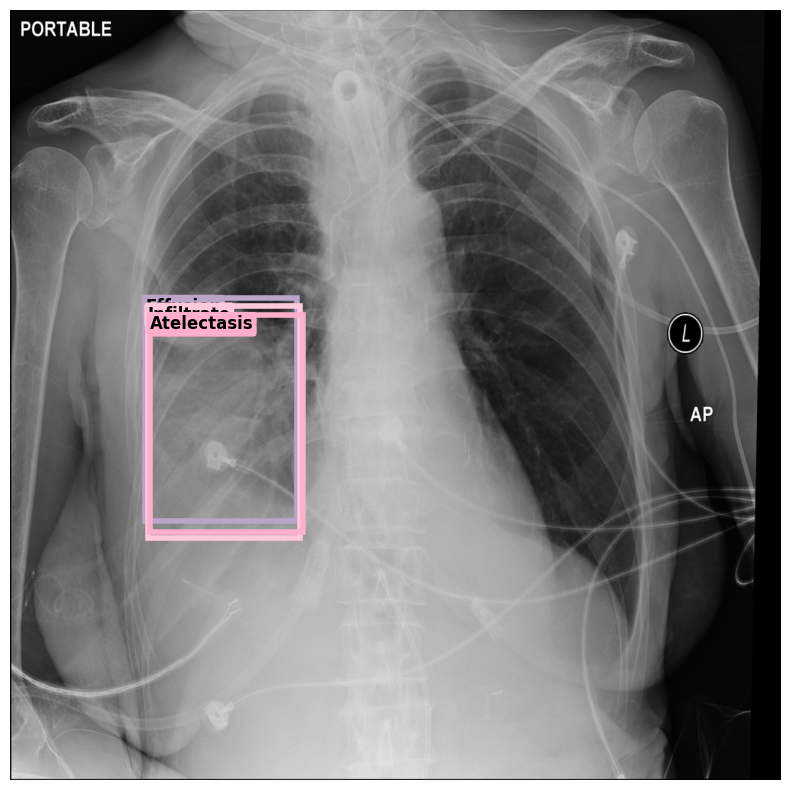

In [7]:
img_ids = ["00018253_059"]

data_path = "/cluster/home/taheeraa/datasets/chestxray-14"
df = get_bboxes(data_path)
for img_id in img_ids:
    img_index = img_id+ '.png' 
    img_path = f"{data_path}/images/{img_index}"
    get_ground_truth_labels(df, img_path, img_index, img_id)

# create input tensors

In [8]:
def load_and_preprocess_images(image_paths, normalize):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize(
            [0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])

    transform = transforms.Compose([
        # Resize the image to the same size expected by the model
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = [transform(Image.open(path).convert('RGB'))
              for path in image_paths]
    batch = torch.stack(images)  # Stack images into a single batch
    
    return batch

image_paths = [f"{data_path}/images/{img_id}.png" for img_id in img_ids]


input_tensors.shape

torch.Size([1, 3, 224, 224])

# create gradcams

In [ ]:
import cv2
import numpy as np

def xai(model, model_str, input_tensor, img_paths, img_ids):
    # Determine target layers based on the model
    if model_str == "densenet121":
        target_layers = [model.features.norm5]
    elif model_str in ["swin_simim", "swin_in22k"]:
        target_layers = [model.layers[-1].blocks[-1].norm2]
        def reshape_transform(tensor, height=7, width=7):
            result = tensor.reshape(tensor.size(0),
                                    height, width, tensor.size(2))
            result = result.transpose(2, 3).transpose(1, 2)
            return result
    elif model_str == "vit_in1k":
        target_layers = [model.blocks[-1].norm1]
        def reshape_transform(tensor, height=14, width=14):
            result = tensor[:, 1:, :].reshape(tensor.size(0),
                                              height, width, tensor.size(2))
            result = result.transpose(2, 3).transpose(1, 2)
            return result

    # Instantiate and configure the Grad-CAM method
    if model_str in ["swin_simim", "swin_in22k", "vit_in1k"]:
        cam = methods["gradcam"](model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    else:
        cam = methods["gradcam"](model=model, target_layers=target_layers)

    cam.batch_size = 32  # Adjust based on GPU memory
    grayscale_cams = cam(input_tensor=input_tensor, targets=None, eigen_smooth=True, aug_smooth=False)

    # Process and save each image in the batch
    for i, grayscale_cam in enumerate(grayscale_cams):
        rgb_img_path = img_paths[i]  # Path to the RGB image for this tensor
        rgb_img = cv2.imread(rgb_img_path, 1)[:, :, ::-1]
        rgb_img = cv2.resize(rgb_img, (224, 224))
        rgb_img = np.float32(rgb_img) / 255

        cam_image = show_cam_on_image(rgb_img, grayscale_cam)
        filename = f"discussion_grid/{img_ids[i]}_{model_str}_grad_cam.png"
        cv2.imwrite(filename, cam_image)

In [9]:
input_tensors = load_and_preprocess_images(image_paths, "imagenet")

xai(model_swin_in22k, "swin_in22k", input_tensors, image_paths, img_ids)

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [10]:
input_tensors = load_and_preprocess_images(image_paths, "chestx-ray")

xai(model_swin_simim, "swin_simim", input_tensors, image_paths, img_ids)

In [13]:
input_tensors = load_and_preprocess_images(image_paths, "imagenet")

xai(model_densenet, "densenet121", input_tensors, image_paths, img_ids)